<a href="https://colab.research.google.com/github/Himika-Mishra/Dissertation/blob/main/Type_1_(Case_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Type 1 (Case 3)

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tqdm import tqdm
import random
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse as sp
from sklearn.metrics import f1_score

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Flatten the images and normalize the pixel values to [0, 1]
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

In [4]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on train_labels
encoder.fit(y_train.reshape(-1, 1))

# Encode the train labels
y_train = encoder.transform(y_train.reshape(-1, 1))
# Convert the csr_matrix to a numpy.ndarray
y_train = y_train.toarray()

# Encode the test labels
y_test = encoder.transform(y_test.reshape(-1, 1))
# Convert the csr_matrix to a numpy.ndarray
y_test = y_test.toarray()

In [5]:
type(y_test)

numpy.ndarray

In [6]:
x_train.shape

(60000, 784)

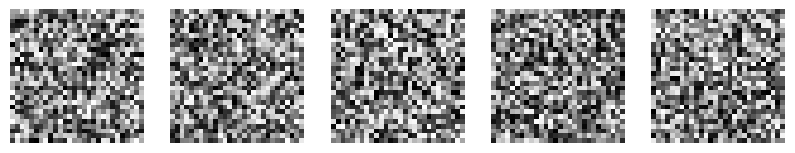

In [7]:
# Generate random noise images
noise_images = np.random.uniform(low=0.0, high=1.0, size=(1000000, 784))

# Plot random 5 noise images
random_indices = np.random.choice(len(noise_images), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, index in enumerate(random_indices):
    noise_image = noise_images[index].reshape(28, 28)
    axes[i].imshow(noise_image, cmap='gray')
    axes[i].axis('off')

plt.show()

In [8]:
# Create a dataframe to store the noisy images
x_train_distorted = pd.DataFrame(noise_images)

In [9]:
len(x_train_distorted)

1000000

In [10]:
# Create a dataframe of array of zeroes as labels for above distorted images
y_train_distorted = np.zeros((1000000, 10))

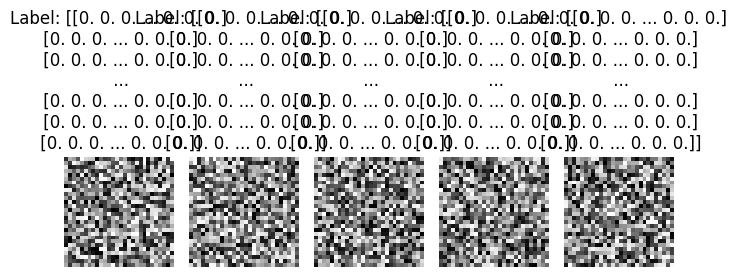

In [11]:
# Select 5 random indices
random_indices = random.sample(range(len(x_train_distorted)), 5)

# Retrieve the distorted images and labels at the selected indices
distorted_images = [noise_images[i] for i in random_indices]
labels = [y_train_distorted for i in random_indices]

# Display the distorted images
for i in range(5):
    image = distorted_images[i]
    label = labels[i]
    
    # Reshape the image back to its original shape (assuming it was flattened)
    image = image.reshape(28, 28)
    
    # Plot the image
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [12]:
# Initialize the merged train dataframe
merged_x_train = pd.DataFrame()

In [13]:
# Define the ratio of distorted images to select
ratios = np.arange(0.1, 1.1, 0.1)

In [14]:
# Convert the distorted train data from list and ndarray to DataFrame
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_train_distorted = pd.DataFrame(x_train_distorted)
y_train_distorted = pd.DataFrame(y_train_distorted)

In [15]:
# Create a DataFrame with uniform distributed noise
np.random.seed(42)

# Initialize lists to store the ratio and F1 scores
ratios = []
f1_scores = []
classification_reports = []

# Define the range for reducing the training set
start_ratio = 0.1
end_ratio = 1.1
increment = 0.1

# Train and evaluate the model 
# Fit a regular MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train, y_train)
# Accuracy Score
test_acc = mlp.score(x_train, y_train)
# print(mlp.score(x_train, y_train))
print(f"Test accuracy with original data(0-9) with original_ratio= 0.0: {test_acc}")

# predictions
pred = mlp.predict(x_test)
print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

# Calculate F1 score and store the ratio, F1 score, and classification report
f1 = f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted')
ratios.append(0.0)
f1_scores.append(f1)
classification_reports.append(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), output_dict=True))

# Iterate over the range and train the MLP model
for ratio in np.arange(start_ratio, end_ratio, increment):
    # Calculate the number of samples to reduce
    num_samples = int(ratio * len(x_train))
    
    # Select random indices to reduce
    reduce_indices = np.random.choice(len(x_train), num_samples, replace=False)
    
    # Reduce the training set
    x_train_reduced = x_train[np.logical_not(np.isin(np.arange(len(x_train)), reduce_indices))]
    y_train_reduced = y_train[np.logical_not(np.isin(np.arange(len(y_train)), reduce_indices))]
    
    # Create a noise DataFrame with the same number of rows as reduced training set
    noise_data = pd.DataFrame(np.random.uniform(size=(num_samples, 784)))
    noise_labels = np.zeros((num_samples, 10))
    
    # Add the noise data to the reduced training set
    x_train_reduced = (np.concatenate([x_train_reduced, noise_data.values]))
    y_train_reduced = np.concatenate([y_train_reduced, noise_labels])

    # # Shuffle the x_train_reduced array
    # x_train_reduced = np.random.shuffle(x_train_reduced)
    # y_train_reduced = np.random.shuffle(y_train_reduced)


    # Train and evaluate the model 
    # Fit a regular MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,8), activation='relu', solver='adam', max_iter=500)
    mlp.fit(x_train_reduced, y_train_reduced)
    # Accuracy Score
    test_acc = mlp.score(x_train_reduced, y_train_reduced)
    # print(mlp.score(x_train_reduced, y_train_reduced))
    print(f"Test accuracy with original data(0-9) with replacing the original training set with noise with original_ratio={ratio}: {test_acc}")

    # predictions
    pred = mlp.predict(x_test)
    print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

    # Calculate F1 score and store the ratio, F1 score, and classification report
    f1 = f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average='weighted')
    ratios.append(ratio)
    f1_scores.append(f1)
    classification_reports.append(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), output_dict=True))

    print("--------------------------------------------------")

Test accuracy with original data(0-9) with original_ratio= 0.0: 0.9385833333333333
[[ 957    0    2    1    0    3    2    9    4    2]
 [  13 1098    7    1    0    1    3    3    9    0]
 [  65    5  914   12    4    2    7    6   13    4]
 [  53    1   18  893    0   21    0    5   12    7]
 [  28    1    1    0  901    1   12    4    4   30]
 [  57    0    5   24    2  775    8    0   12    9]
 [  46    1    3    1    3    7  893    0    4    0]
 [  44    4   19    6    3    0    0  932    0   20]
 [  55   10    3    5    4   13    8    2  865    9]
 [  30    4    0   13   29   10    1   14    7  901]]
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       980
           1       0.98      0.97      0.97      1135
           2       0.94      0.89      0.91      1032
           3       0.93      0.88      0.91      1010
           4       0.95      0.92      0.93       982
           5       0.93      0.87      0.90       892
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

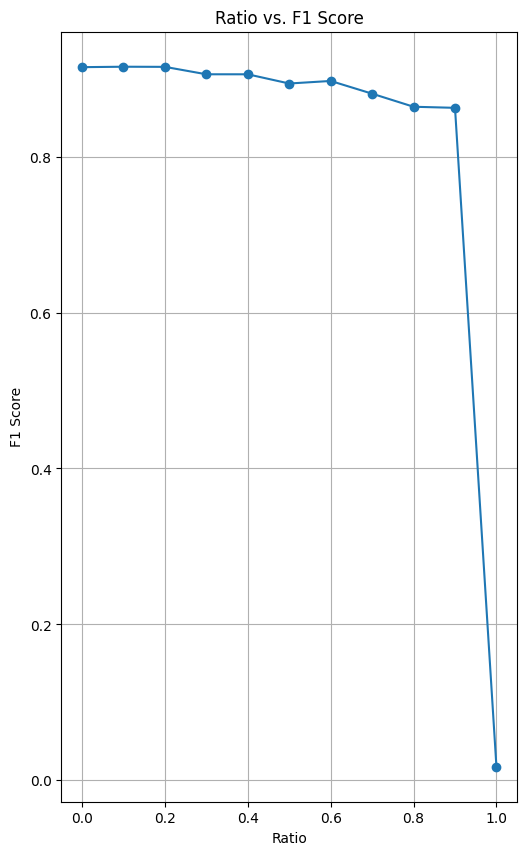

In [16]:
# Plot the ratio vs. F1 score
# plt.figure(figsize=(12, 4))
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.plot(ratios, f1_scores, marker='o')
plt.xlabel('Ratio')
plt.ylabel('F1 Score')
plt.title('Ratio vs. F1 Score')
plt.grid(True)

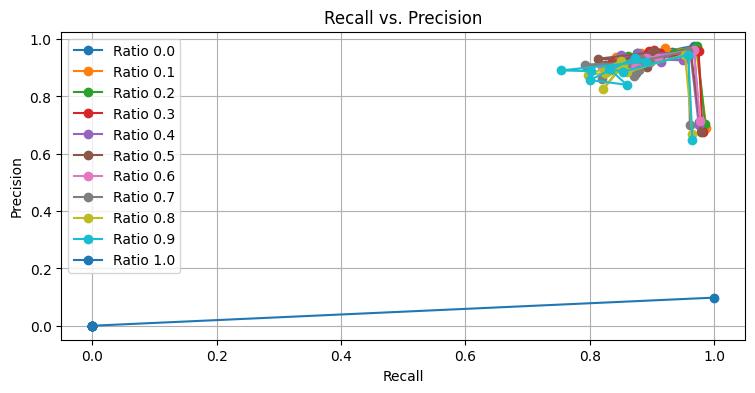

In [17]:
# Plot the recall vs. precision
plt.figure(figsize=(30, 4))
plt.subplot(1, 3, 2)
for i, ratio in enumerate(ratios):
    report = classification_reports[i]
    recall = [report[label]['recall'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    precision = [report[label]['precision'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    plt.plot(recall, precision, marker='o', label=f'Ratio {ratio:.1f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs. Precision')
plt.legend()
plt.grid(True)

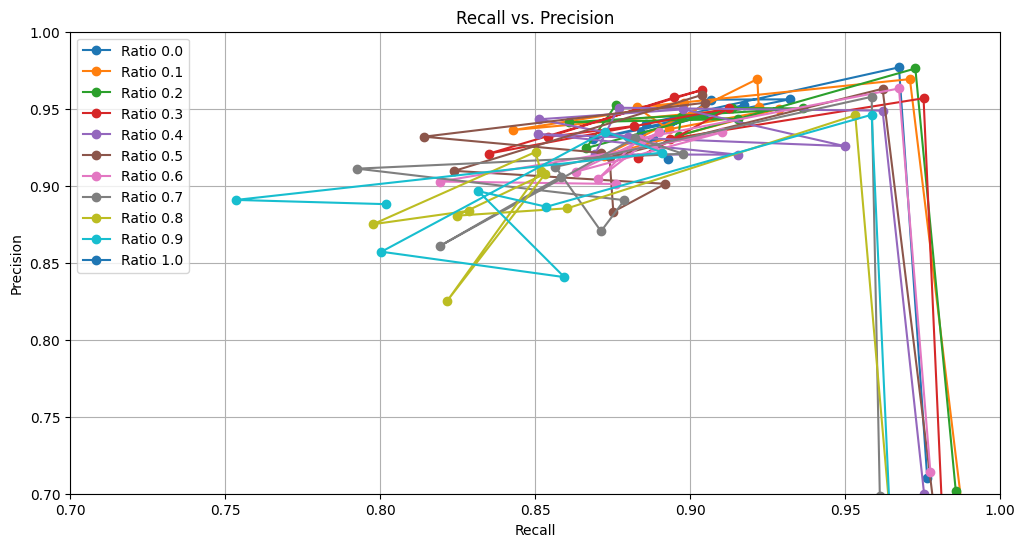

In [18]:
plt.figure(figsize=(12, 6))  # Increase the figure size (adjust as needed)

# Plot the recall vs precision
for i, ratio in enumerate(ratios):
    report = classification_reports[i]
    recall = [report[label]['recall'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    precision = [report[label]['precision'] for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]
    plt.plot(recall, precision, marker='o', label=f'Ratio {ratio:.1f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs. Precision')
plt.legend()
plt.grid(True)

plt.xlim(0.7, 1.0)  # Set x-axis limits
plt.ylim(0.7, 1.0)  # Set y-axis limits

plt.show()

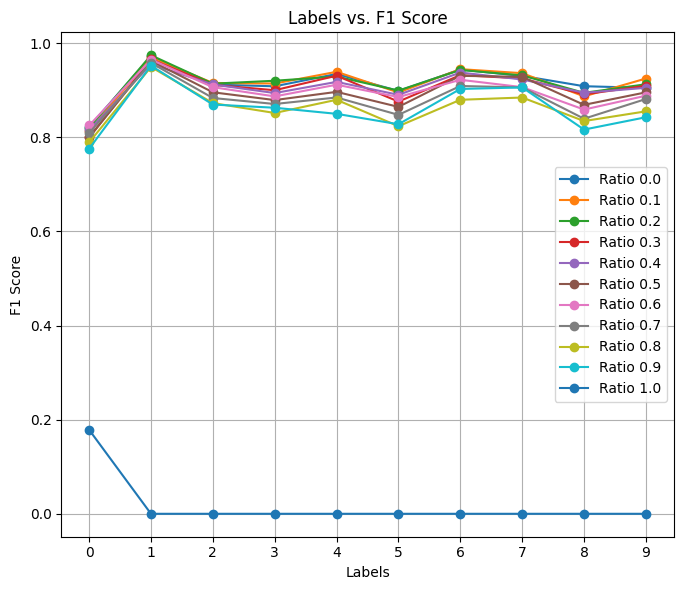

In [19]:
plt.figure(figsize=(20, 6))

# Plot the labels vs. F1 score
plt.subplot(1, 3, 3)
for i, ratio in enumerate(ratios):
    report = classification_reports[i]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    f1_scores = [report[label]['f1-score'] for label in labels]
    plt.plot(labels, f1_scores, marker='o', label=f'Ratio {ratio:.1f}')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('Labels vs. F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()